# Quick Check
[Algorithms evaluated and evaluation setting](#Algorithms-Evaluated)  
[Results](#Speed)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Functions Evaluated 

Notes: 
- Although you have set the random seed for `F3(x)`, the implementation of random number is different on various platforms, thus the evaluation on `F3(x)` can vary according to the platform. 
- Changed a bit on the `F3` implementation.

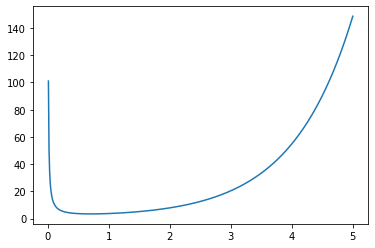

In [2]:
def F1(x):
    return np.exp(x) + 1 / x


x_grid = np.linspace(0.01, 5, 501)
f_grid = F1(x_grid)
plt.plot(x_grid, f_grid)
plt.show()

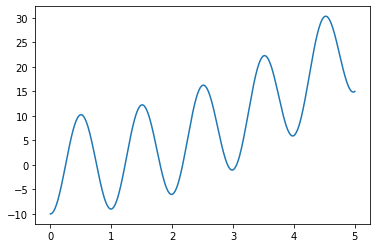

In [3]:
def F2(x):
    return x * x - 10 * np.cos(2 * np.pi * x)


x_grid = np.linspace(0, 5, 501)
f_grid = F2(x_grid)
plt.plot(x_grid, f_grid)
plt.show()

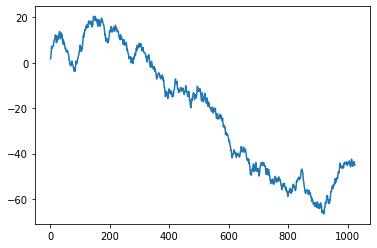

In [4]:
def F3_generator():
    np.random.seed(0)
    r = np.random.randn(1024)
    rw = r.cumsum()  # cumulative sum
    return lambda x: np.interp(x, np.arange(1024), rw)


F3 = F3_generator()

x_grid = np.linspace(0, 1024, 10001)
f_grid = F3(x_grid)
plt.plot(x_grid, f_grid)
plt.show()

# Minimum
- $F1$ on interval (0,5) is a convex function, we can simply find its minimum. 
- $F2$ on interval (0,5) has minimum when x = 0. 
- $F3$ on interval (0,1024) is linear interpolation, which has extremum on the value it interpolated.  

In [5]:
import scipy.optimize as opt

F1_der = lambda x: np.exp(x) - 1 / x ** 2
F1_min = F1(opt.newton(F1_der, 0.7, maxiter=1000, tol=1e-8))
print(f"F1_min: {F1_min}")

F2_min = F2(0)
print(f"F2_min: {F2_min}")

F3_min = np.inf
for x in x_grid:
    y = F3(x)
    if F3_min > y:
        F3_min = y
print(f"F3_min: {F3_min}")

F1_min: 3.442277294494974
F2_min: -10.0
F3_min: -66.54091993268368


# Algorithms Evaluated

1. Newton's method
2. Secant method 
3. Gradient descent
4. Gradient descent with Fixed initial $x_0$
5. Random search
6. Simulated annealing

For simplicity, the **speed** is evaluated with the return times in 5 s. All the algorithms are implemented with python.

The **accuracy** is defined with the $L_1$ distance to the global minimum. 

Notes: 
- I cannot see the point to evaluate the gradient descent with a fixed initial $x_0$, choosing different initial state will have different results.  
- 1, 2, 3, 4 is based on numerical derivative.
- For all experiments, the random seed is set to 0. 
- Each algorithm will be allowed to run 5 seconds. For simplicity, the time is counted with the python `time` module. 
- Step size for 3 is 1e-3, results may vary with different hyper-parameter.   
- The 5, 6 do not have converge guarantee, I run them for fixed number, this hyper-parameter is not turned, results may vary with different hyper-parameters.   

## Evaluating Utilities

In [6]:
import time


def numerical_der(x, f, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

## Newton's method
Second oder derivative equals to 0. 

In [7]:
def newton(F_name: str, time_lim: float = 5.0, eps: float = 1e-5):
    F = eval(F_name)
    # f is the first order derivative of F
    f = lambda x: numerical_der(x, F)

    np.random.seed(0)

    ret_times = 0
    dist_sum = 0
    start = time.time()
    while True:
        if "3" in F_name:
            x0 = np.random.uniform(0, 1024)
        else:
            x0 = np.random.uniform(0, 5)

        # Second order derivitive of f
        x1 = x0 - f(x0) / (numerical_der(x0, f) + eps)  # + eps for numerical stability
        while abs(x1 - x0) > eps and time.time() - start < time_lim:
            x0 = x1
            x1 = x0 - f(x0) / (numerical_der(x0, f) + eps)

        ret_times += 1
        dist_sum += abs(F(x1) - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_newton(F_name):
    running_time = 5.0

    ret_times, dist_sum = newton(F_name, running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Secant method
**Algorithm**

1. Start with two initial points $x_0$, $x_1$
2. Compute $x_{n+1}=x_n-f(x_n)\frac{x_n-x_{n-1}}{f(x_n)-f(x_{n-1})}$
3. Test whether $|x_{n+1}-x_n|<\epsilon$, if yes then you have found 0, if no then repeat 2.

In [10]:
def secant(F_name: str, time_lim: float = 5.0, eps: float = 1e-5):
    F = eval(F_name)
    # f is the first order derivative of F
    f = lambda x: numerical_der(x, F)

    np.random.seed(0)
    ret_times = 0
    dist_sum = 0
    start = time.time()
    while True:
        if "3" in F_name:
            x0 = np.random.uniform(0, 1024)
            x1 = np.random.uniform(0, 1024)
        else:
            x0 = np.random.uniform(0, 5)
            x1 = np.random.uniform(0, 5)
        while abs(x1 - x0) > eps and time.time() - start < time_lim:
            x2 = x1 - f(x1) * (x1 - x0) / (
                f(x1) - f(x0) + eps
            )  # + eps for numerical stability
            x0 = x1
            x1 = x2

        ret_times += 1
        dist_sum += abs(F(x1) - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_secant(F_name):
    running_time = 5.0

    ret_times, dist_sum = secant(F_name, running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Gradient Descent

In [12]:
def sgd(F_name: str, lr: float = 1e-3, time_lim: float = 5.0, eps: float = 1e-5):
    F = eval(F_name)

    np.random.seed(0)
    ret_times = 0
    dist_sum = 0
    start = time.time()

    while True:
        if "3" in F_name:
            x0 = np.random.uniform(0, 1024)
        else:
            x0 = np.random.uniform(0, 5)

        grad = numerical_der(x0, F)
        while grad > eps and time.time() - start < time_lim:
            grad = numerical_der(x0, F)
            x0 = x0 - lr * grad

        ret_times += 1
        dist_sum += abs(F(x0) - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_sgd(F_name):
    running_time = 5.0

    ret_times, dist_sum = sgd(F_name, time_lim=running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Gradient Descent with Fixed Initial $x_0$

In [37]:
def sgd_fi(F_name: str, lr: float = 1e-3, time_lim: float = 5.0, eps: float = 1e-5):
    F = eval(F_name)

    np.random.seed(0)
    ret_times = 0
    dist_sum = 0
    start = time.time()
    
    # Fixed initial x0
    if "3" in F_name:
        x0 = np.random.uniform(0, 1024)
    else:
        x0 = np.random.uniform(0, 5)

    while True:
        grad = numerical_der(x0, F)
        while grad > eps and time.time() - start < time_lim:
            grad = numerical_der(x0, F)
            x0 = x0 - lr * grad

        ret_times += 1
        dist_sum += abs(F(x0) - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_sgd_fi(F_name):
    running_time = 5.0

    ret_times, dist_sum = sgd_fi(F_name, time_lim=running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Random Search
For fairness, I did not generate a batch of random number in numpy array, but generate the input one by one.  
The random sample size for `F1` and `F2` is 50, for `F3` is 10240.  
The result here is relative good, but  obviously this approach is hard to scale up to higher dimensions. 

In [14]:
import random


def random_search(F_name, time_lim):
    F = eval(F_name)

    np.random.seed(0)
    if "3" in F_name:
        scale = 1024
        sample_size = 10240
    else:
        scale = 5
        sample_size = 50

    ret_times = 0
    dist_sum = 0
    start = time.time()
    while True:
        current_min = np.inf
        for _ in range(sample_size):
            x = random.random() * scale
            value = F(x)
            if value < current_min:
                current_min = value
            if time.time() - start > time_lim:
                break

        ret_times += 1
        dist_sum += abs(current_min - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_random_search(F_name):
    running_time = 5.0

    ret_times, dist_sum = random_search(F_name, time_lim=running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Simulated Annealing

Adapt the code in class to continuous variables.   
The $T$ for `F1` and `F2` is 50, for `F3` is 10240. 

In [16]:
def metropolis_criterion(xj, xi, T, f):
    if f(xj) < f(xi):
        return True
    else:
        if random.random() < np.exp(-(f(xj) - f(xi)) / T):
            return True
        else:
            return False


def neighbor(x, xMin, xMax):
    """pick neighbor randomly"""
    newGuess = xMin + random.random() * (xMax - xMin)
    return newGuess


def cooling(T):
    return T * 0.95


def sa(F_name, time_lim):
    F = eval(F_name)

    np.random.seed(0)
    if "3" in F_name:
        x0 = np.random.uniform(0, 1024)
        xMin, xMax, T = 0, 1024, 10240
    else:
        x0 = np.random.uniform(0, 5)
        xMin, xMax, T = 0, 5, 50

    ret_times = 0
    dist_sum = 0
    start = time.time()
    while True:
        _T = T
        while _T > 0.01 and time.time() - start <= time_lim:
            x1 = neighbor(x0, xMin, xMax)
            if metropolis_criterion(x1, x0, _T, F):
                x0 = x1
            _T = cooling(_T)

        ret_times += 1
        dist_sum += abs(F(x0) - eval(f"{F_name}_min"))

        if time.time() - start > time_lim:
            break

    return ret_times, dist_sum


def eval_sa(F_name):
    running_time = 5.0

    ret_times, dist_sum = sa(F_name, time_lim=running_time)
    print(f"{F_name} return {ret_times} times in {running_time} s")
    print(f"The average distance to the minimum is {dist_sum/ret_times}")
    print("---")

    return ret_times, dist_sum / ret_times

## Evaluate All

In [44]:
df_dict = {"algo": [], "func": [], "return_times": [], "ave_dist": []}

print_red = lambda x: print("\033[93m " + x + "\x1b[0m")

for algo in ["newton", "secant", "sgd", "sgd_fi", "random_search", "sa"]:
    for F in ["F1", "F2", "F3"]:
        print_red(f"--- {algo}-{F} ---")
        t, ave_dist = eval(f"eval_{algo}('{F}')")
        df_dict["algo"].append(algo)
        df_dict["func"].append(F)
        df_dict["return_times"].append(t)
        df_dict["ave_dist"].append(ave_dist)

 --- newton-F1 ---
F1 return 39659 times in 5.0 s
The average distance to the minimum is 1.9032714641875776e-16
---
 --- newton-F2 ---
F2 return 76 times in 5.0 s
The average distance to the minimum is 76.93919199538695
---
 --- newton-F3 ---
F3 return 46235 times in 5.0 s
The average distance to the minimum is 44.29433223321052
---
 --- secant-F1 ---
F1 return 33527 times in 5.0 s
The average distance to the minimum is 0.0001293486026820099
---
 --- secant-F2 ---
F2 return 19048 times in 5.0 s
The average distance to the minimum is 129.44296552821956
---
 --- secant-F3 ---
F3 return 10023 times in 5.0 s
The average distance to the minimum is 44.154638487618286
---
 --- sgd-F1 ---
F1 return 568 times in 5.0 s
The average distance to the minimum is 0.6149483514960852
---
 --- sgd-F2 ---
F2 return 37072 times in 5.0 s
The average distance to the minimum is 12.437473681455211
---
 --- sgd-F3 ---
F3 return 68 times in 5.0 s
The average distance to the minimum is 44.605815073995025
---
 ---

### Speed

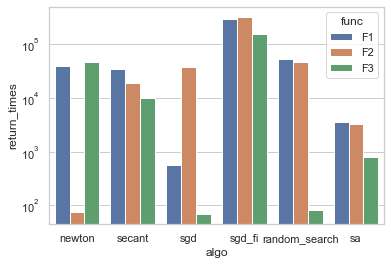

In [45]:
sns.set_theme(style="whitegrid")
df = pd.DataFrame.from_dict(df_dict)
ax = sns.barplot(x="algo", y="return_times", hue="func", data=df)
ax.set_yscale('log')

- The y-axis is the return times for an algorithm in 5 seconds. The higher the return times is, the faster the algorithm runs.  
- Newton-F2 has a bed running speed is because it is relatively hard to converge on its second order derivative.  
- The gradient descent with fixed initial $x_0$ (sgd_fi) initialize with a fixed initial $x_0$ as shown on the [previous code](#Gradient-Descent-with-Fixed-Initial-x0x_0). 
- The results of random search and sa is depended on the batch size and initial temperature respectively, [check previous code](#Random-Search) for details.  

### Accuracy

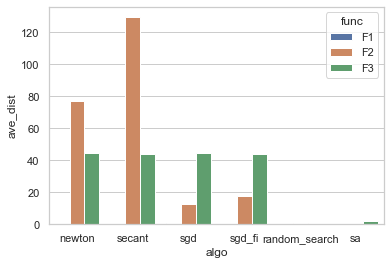

In [46]:
df = pd.DataFrame.from_dict(df_dict)
ax = sns.barplot(x="algo", y="ave_dist", hue="func", data=df)

- The accuracy is defined with the  $L_1$  distance to the global minimum, the smaller the value is, the accurate it is.  
- For $F1$, since it is a convex function, all algorithms perform well.
- Random search, SA have good performance on the `F2` and `F3`, but they also require a long time run as show in [speed](#Speed) section. As the dimension increases, we can also expect they perform worse.    